In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [67]:
movies = pd.read_csv('~/Movie_Recommender/movies.csv')
ratings = pd.read_csv('~/Movie_Recommender/ratings.csv')

## MovieLens EDA

In [74]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
print('There are {} unique users rating {} unique movies in the dataset'.format(n_users, n_movies))

There are 610 unique users rating 9724 unique movies in the dataset


[Text(0.5, 1.0, 'Distribution of Ratings on a 0.5 to 5 scale')]

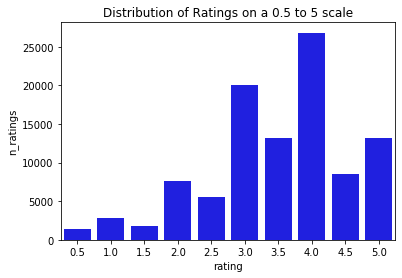

In [75]:
#Ratings distribution
rpr = ratings.groupby('rating').userId.count().reset_index().rename(columns={'userId': 'n_ratings'})
rating_dist = sns.barplot(data=rpr, x='rating', y='n_ratings', color='b')
rating_dist.set(title='Distribution of Ratings on a 0.5 to 5 scale')

3446 of the 9724 unique movies, or 35.4%, were rated only once


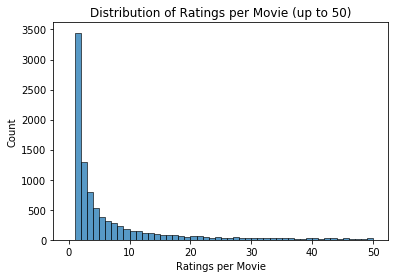

In [76]:
#Number of ratings per movie distribution
rpm = sns.histplot(ratings.movieId.value_counts(), binrange = (0,50), binwidth=1)
rpm.set(xlabel ="Ratings per Movie", ylabel = "Count", title ='Distribution of Ratings per Movie (up to 50)')
movies_rated_once = sum(ratings.movieId.value_counts() == 1)
print('{} of the {} unique movies, or {}%, were rated only once'.format(movies_rated_once, n_movies, round(movies_rated_once/n_movies, 3) * 100))

112 out of 610 users, or 18.4%, rated less than 30 movies


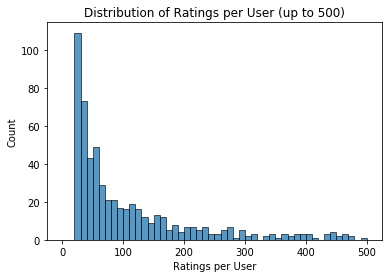

In [77]:
#Number of ratings per user distribution
rpu = sns.histplot(ratings.userId.value_counts(), binrange = (0,500), binwidth=10)
rpu.set(xlabel ="Ratings per User", ylabel = "Count", title ='Distribution of Ratings per User (up to 500)')
users_rating_30 = sum(ratings.userId.value_counts() <= 30)
print('{} out of {} users, or {}%, rated less than 30 movies'.format(users_rating_30, n_users, round(users_rating_30/n_users, 3) * 100))

## SVD EDA

In [29]:
from surprise import accuracy, SVD, Reader, Dataset
from surprise.model_selection import train_test_split

In [30]:
#Train baseline SVD model
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader=reader)

algo = SVD()

train, test = train_test_split(data, test_size=0.25)

algo.fit(train)

In [31]:
#Generate predictions
predictions = algo.test(test)
print(accuracy.rmse(predictions, verbose=True))
predictions[:5]

RMSE: 0.8758
0.8758380909117233


[Prediction(uid=414, iid=1275, r_ui=4.0, est=3.918313987070052, details={'was_impossible': False}),
 Prediction(uid=448, iid=34048, r_ui=3.0, est=2.9333623102464372, details={'was_impossible': False}),
 Prediction(uid=553, iid=44665, r_ui=4.0, est=4.379196883988721, details={'was_impossible': False}),
 Prediction(uid=177, iid=4896, r_ui=5.0, est=3.6427098478993636, details={'was_impossible': False}),
 Prediction(uid=567, iid=136016, r_ui=1.0, est=2.338900508641876, details={'was_impossible': False})]

In [78]:
predictions_df = pd.DataFrame(predictions)
predictions_df.head()

,uid,iid,r_ui,est,details
0,414,1275,4.0,3.918314,{'was_impossible': False}
1,448,34048,3.0,2.933362,{'was_impossible': False}
2,553,44665,4.0,4.379197,{'was_impossible': False}
3,177,4896,5.0,3.642710,{'was_impossible': False}
4,567,136016,1.0,2.338901,{'was_impossible': False}


In [79]:
#Create auxiliary dataframes
rpm_df = ratings.groupby('movieId').userId.nunique().reset_index().rename(columns={'userId': 'n_users_per_movie'})
rpu_df = ratings.groupby('userId').movieId.nunique().reset_index().rename(columns={'movieId': 'n_movies_per_user'})

In [80]:
#Add columns to predictions dataframe, including the prediction error
predictions_df_full = predictions_df.merge(rpm_df, how='left', left_on='iid', right_on='movieId').merge(rpu_df, how='left', left_on='uid', right_on='userId')
predictions_df_full.drop(columns=['movieId', 'userId'], inplace=True)
predictions_df_full['pred_err'] = abs(predictions_df_full.r_ui - predictions_df_full.est)
predictions_df_full.head(5)

,uid,iid,r_ui,est,details,n_users_per_movie,n_movies_per_user,pred_err
0,414,1275,4.0,3.918314,{'was_impossible': False},48,2698,0.081686
1,448,34048,3.0,2.933362,{'was_impossible': False},50,1864,0.066638
2,553,44665,4.0,4.379197,{'was_impossible': False},38,83,0.379197
3,177,4896,5.0,3.642710,{'was_impossible': False},107,904,1.357290
4,567,136016,1.0,2.338901,{'was_impossible': False},4,385,1.338901


In [81]:
#Add pred_type column to predictions dataframe, based on the pred_error
best_cutoff = predictions_df_full.pred_err.quantile(0.1)
worst_cutoff = predictions_df_full.pred_err.quantile(0.9)
predictions_df_full['pred_type'] = predictions_df_full.apply(lambda x: 'best' if x.pred_err <= best_cutoff else ('medium' if x.pred_err <= worst_cutoff else 'worst'), axis=1)
predictions_df_full.head(5)

,uid,iid,r_ui,est,details,n_users_per_movie,n_movies_per_user,pred_err,pred_type
0,414,1275,4.0,3.918314,{'was_impossible': False},48,2698,0.081686,best
1,448,34048,3.0,2.933362,{'was_impossible': False},50,1864,0.066638,best
2,553,44665,4.0,4.379197,{'was_impossible': False},38,83,0.379197,medium
3,177,4896,5.0,3.642710,{'was_impossible': False},107,904,1.357290,medium
4,567,136016,1.0,2.338901,{'was_impossible': False},4,385,1.338901,medium


[Text(0, 0.5, 'Percent'),
 Text(0.5, 0, 'Users per Movie'),
 Text(0.5, 1.0, 'Distribution of Users per Movie (up to 100)')]

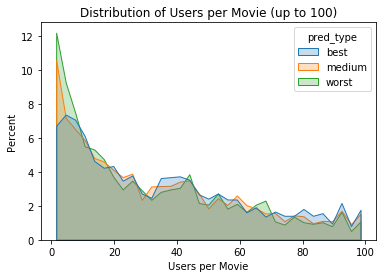

In [82]:
#Distribution of best, medium, and worst predictions as a function of n_users_per_movie
preds_rpm_plot = sns.histplot(data=predictions_df_full, x='n_users_per_movie', binrange = (0,100), stat='percent', common_norm=False, hue='pred_type', element='poly')
preds_rpm_plot.set(xlabel ="Users per Movie", ylabel = "Percent", title ='Distribution of Users per Movie (up to 100)')

The hypothesis is that more Users per Movie (UPM) should improve prediction quality. The chart above supports this to a degree as the worst predictions have the highest proportion of movies with low UPM, followed by the medium predictions and lastly the best predictions. We also see the relative densities flip starting around 20 UPM, with the best predictions having the highest proportion of ratings compared to the medium and worst predictions. However, there are still a very large number of poor predictions with high UPMs and precise predictions with low UPMs, indicating that there may be more at play than just UPM when it comes to prediction quality. 

[Text(0, 0.5, 'Percent'),
 Text(0.5, 0, 'Movie Rating Variance'),
 Text(0.5, 1.0, 'Distribution of Variance of Movie Ratings by Prediction Type (up to 3)')]

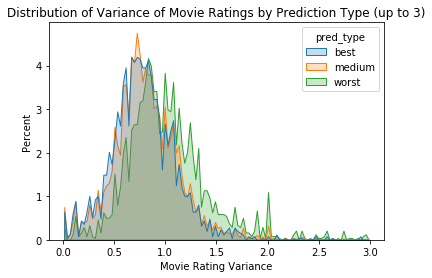

In [85]:
#Range of ratings in best, medium, and worst predictions (take range from full ratings dataset and filter on movies that were predicted)
range_df = ratings.groupby('movieId').rating.var()
range_df = range_df.reset_index().rename(columns={'rating': 'rating_var'})
range_df
predictions_df_full = predictions_df_full.merge(range_df, how='left', left_on='iid', right_on='movieId')
var_plot = sns.histplot(data=predictions_df_full, x='rating_var', stat='percent', binrange=(0,3), common_norm=False, hue = 'pred_type', element='poly')
var_plot.set(xlabel ="Movie Rating Variance", ylabel = "Percent", title ='Distribution of Variance of Movie Ratings by Prediction Type (up to 3)')

To further explore the factors that impact prediction quality, we looked at the ratings variance of our predicted movies (with more than one rating). In theory, more polarizing movies (higher variance) are more difficult to predict and should lead to worse prediction quality. As we see from the chart above, the best and medium predictions' movies have variance distributions shifted left of the worst predictions' movies. The best and medium distributions are centered around ~0.75 variance whereas the worst distribution is centered closer to 1, with a much longer right tail. In conclusion, prediction quality is likely a function of UPM and movie polarization, among other factors.